In [ ]:
# Check GPU (should be enabled from Runtime > Change runtime type > GPU)
!nvidia-smi

# Install required libs
!pip install torch torchvision pandas scikit-learn matplotlib


Sat May 17 05:34:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle --upgrade
!pip install opencv-python-headless


import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")


DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Colab_Projects/ODIR_MultiModal'
!mkdir -p "{DRIVE_PROJECT_PATH}"
!mkdir -p "{DRIVE_PROJECT_PATH}/data"
!mkdir -p "{DRIVE_PROJECT_PATH}/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Current GPU: Tesla T4


In [ ]:

from google.colab import files
print("Please upload your kaggle.json file")
uploaded = files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured.")


KAGGLE_DATA_PATH_GDRIVE = f"{DRIVE_PROJECT_PATH}/data/ODIR-5K-Raw"

KAGGLE_DATA_PATH_COLAB = "/content/ODIR-5K-Raw"


TARGET_KAGGLE_DATA_PATH = KAGGLE_DATA_PATH_COLAB


!mkdir -p "{TARGET_KAGGLE_DATA_PATH}"


!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k -p "{TARGET_KAGGLE_DATA_PATH}" --unzip

print(f"Dataset downloaded and unzipped to: {TARGET_KAGGLE_DATA_PATH}")
!ls -lh "{TARGET_KAGGLE_DATA_PATH}"



CSV_NAME = 'full_df.csv'
IMAGE_FOLDER_NAME = 'preprocessed_images'

DATA_DIR_COLAB = TARGET_KAGGLE_DATA_PATH
IMG_DIR_COLAB = f"{DATA_DIR_COLAB}/{IMAGE_FOLDER_NAME}"
CSV_PATH_COLAB = f"{DATA_DIR_COLAB}/{CSV_NAME}"


DATA_DIR_GDRIVE = f"{DRIVE_PROJECT_PATH}/data/ODIR-5K"
IMG_DIR_GDRIVE = f"{DATA_DIR_GDRIVE}/{IMAGE_FOLDER_NAME}"
CSV_PATH_GDRIVE = f"{DATA_DIR_GDRIVE}/{CSV_NAME}"


DATA_DIR = TARGET_KAGGLE_DATA_PATH
IMG_DIR = f"{TARGET_KAGGLE_DATA_PATH}/{IMAGE_FOLDER_NAME}"
CSV_PATH = f"{TARGET_KAGGLE_DATA_PATH}/{CSV_NAME}"

print(f"Using Image Directory: {IMG_DIR}")
print(f"Using CSV Path: {CSV_PATH}")


!ls -lh "{IMG_DIR}" | head -n 5
!ls -lh "{CSV_PATH}"

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API configured.
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 99% 1.60G/1.62G [00:08<00:00, 252MB/s]
100% 1.62G/1.62G [00:08<00:00, 209MB/s]
Dataset downloaded and unzipped to: /content/ODIR-5K-Raw
total 1.7M
-rw-r--r-- 1 root root 1.5M May 17 05:50 full_df.csv
drwxr-xr-x 3 root root 4.0K May 17 05:50 ODIR-5K
drwxr-xr-x 2 root root 228K May 17 05:50 preprocessed_images
Using Image Directory: /content/ODIR-5K-Raw/preprocessed_images
Using CSV Path: /content/ODIR-5K-Raw/full_df.csv
total 392M
-rw-r--r-- 1 root root  42K May 17 05:50 0_left.jpg
-rw-r--r-- 1 root root  43K May 17 05:50 0_right.jpg
-rw-r--r-- 1 root root  50K May 17 05:50 1005_right.jpg
-rw-r--r-- 1 root root  62K May 17 05:50 1006_left.jpg
-rw-r--r-- 1 root root 1.5M May 17 05:50 /content/ODIR-5K-Raw/full_df.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, hamming_loss


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


from tqdm.auto import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4


BEST_MODEL_SAVE_PATH = f"{DRIVE_PROJECT_PATH}/models/best_multimodal_odir_model_colab.pth"
print(f"Best model will be saved to: {BEST_MODEL_SAVE_PATH}")

Using device: cuda
Best model will be saved to: /content/drive/MyDrive/Colab_Projects/ODIR_MultiModal/models/best_multimodal_odir_model_colab.pth


DataFrame Head:
   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild non

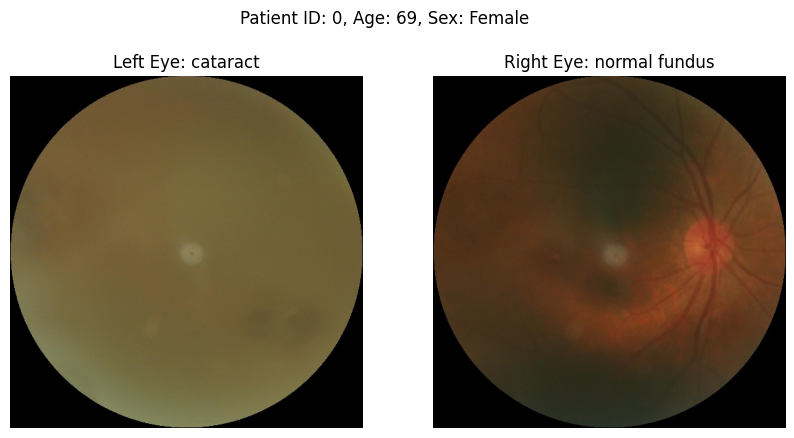

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


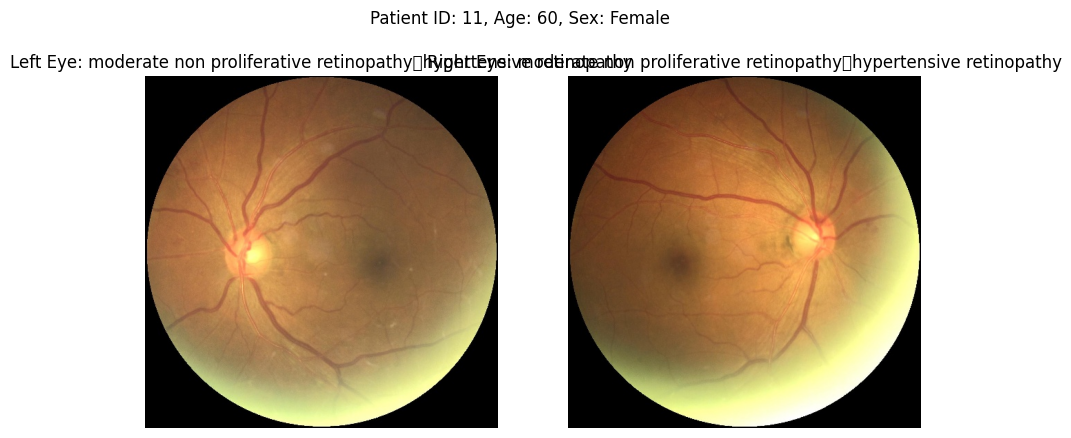

In [ ]:

df = pd.read_csv(CSV_PATH)

print("DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()
print("\nDataFrame Description:")
print(df.describe(include='all'))


label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']


def display_sample_image(row_index):

    left_img_path = os.path.join(IMG_DIR, df.loc[row_index, 'Left-Fundus'])
    right_img_path = os.path.join(IMG_DIR, df.loc[row_index, 'Right-Fundus'])

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    try:
        left_img = Image.open(left_img_path)
        ax[0].imshow(left_img)
        ax[0].set_title(f"Left Eye: {df.loc[row_index, 'Left-Diagnostic Keywords']}")
        ax[0].axis('off')
    except FileNotFoundError:
        print(f"Error: Left image not found at {left_img_path}")
        ax[0].set_title(f"Left Eye: Image not found\n...")
        ax[0].axis('off')

    try:
        right_img = Image.open(right_img_path)
        ax[1].imshow(right_img)
        ax[1].set_title(f"Right Eye: {df.loc[row_index, 'Right-Diagnostic Keywords']}")
        ax[1].axis('off')
    except FileNotFoundError:
        print(f"Error: Right image not found at {right_img_path}")
        ax[1].set_title(f"Right Eye: Image not found\n...")
        ax[1].axis('off')

    plt.suptitle(f"Patient ID: {df.loc[row_index, 'ID']}, Age: {df.loc[row_index, 'Patient Age']}, Sex: {df.loc[row_index, 'Patient Sex']}")
    plt.show()


if os.path.exists(os.path.join(IMG_DIR, df.loc[0, 'Left-Fundus'])):
    display_sample_image(0)
else:
    print(f"Sample image display skipped, file not found: {os.path.join(IMG_DIR, df.loc[0, 'Left-Fundus'])}")

if os.path.exists(os.path.join(IMG_DIR, df.loc[10, 'Left-Fundus'])):
     display_sample_image(10)
else:
    print(f"Sample image display skipped, file not found: {os.path.join(IMG_DIR, df.loc[10, 'Left-Fundus'])}")


Patient Sex unique values: ['Female' 'Male']


<ipython-input-10-7178502ac545>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Left-Diagnostic Keywords'].fillna('', inplace=True)
<ipython-input-10-7178502ac545>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

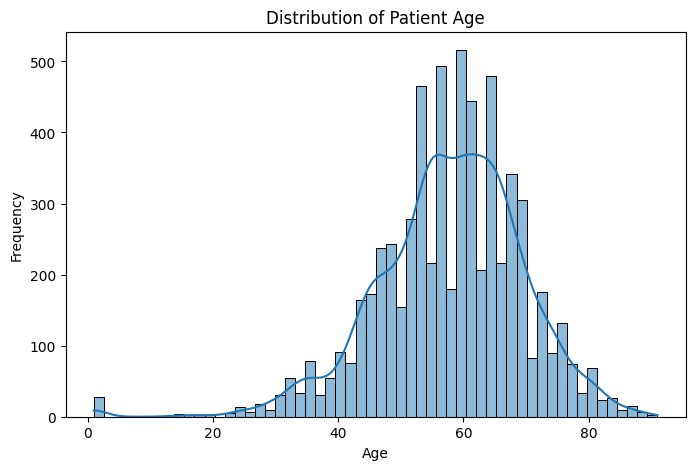

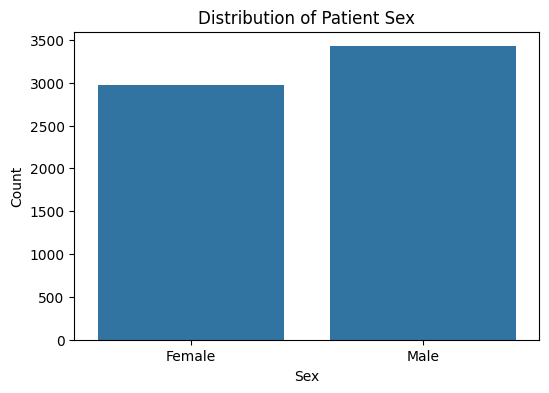

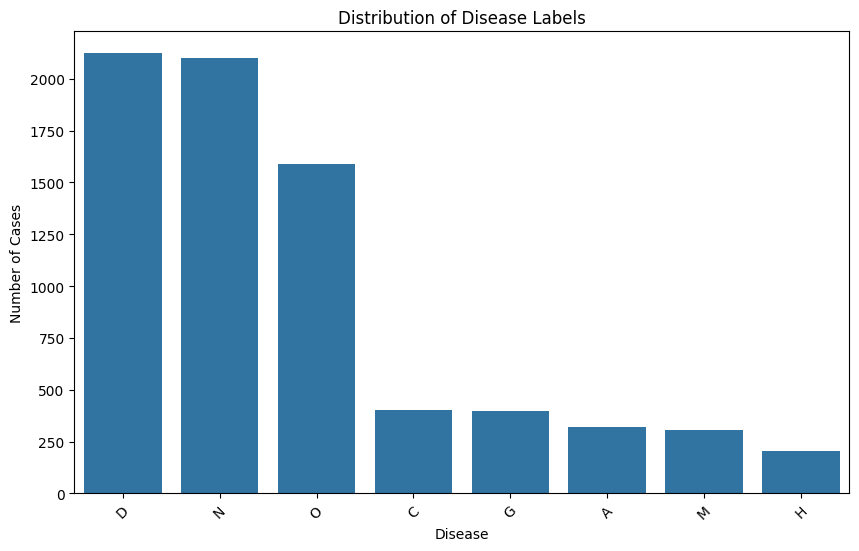


Label Counts:
 D    2123
N    2101
O    1588
C     402
G     397
A     319
M     306
H     203
dtype: int64


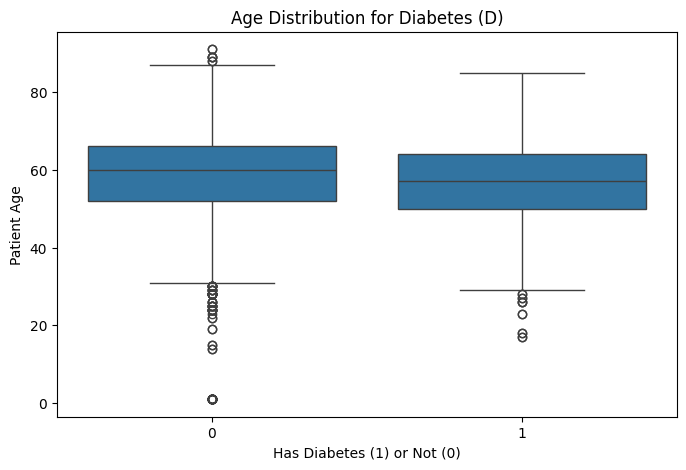

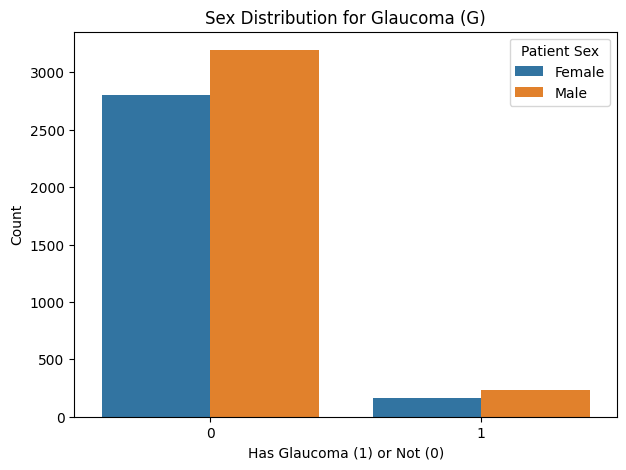

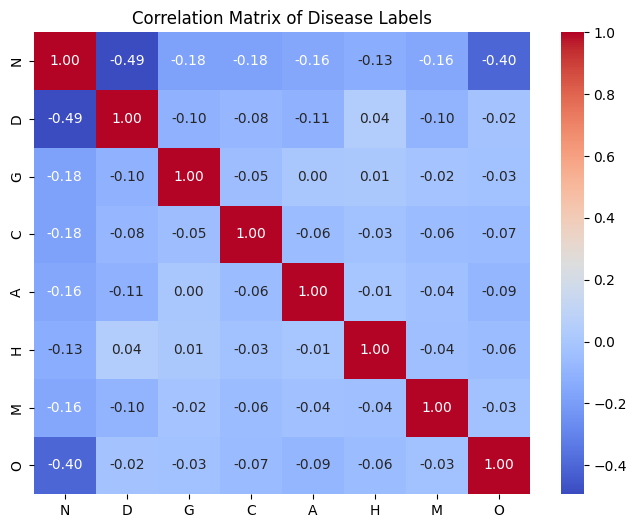

Filtered out 324 rows due to missing images.


<ipython-input-10-7178502ac545>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(int)
<ipython-input-10-7178502ac545>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(int)
<ipython-input-10-7178502ac545>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [ ]:
#eda

df['Patient Age'] = pd.to_numeric(df['Patient Age'], errors='coerce')
df.dropna(subset=['Patient Age'], inplace=True)
df['Patient Age'] = df['Patient Age'].astype(int)


print("\nPatient Sex unique values:", df['Patient Sex'].unique())


df['Left-Diagnostic Keywords'].fillna('', inplace=True)
df['Right-Diagnostic Keywords'].fillna('', inplace=True)
df['Combined_Keywords'] = df['Left-Diagnostic Keywords'] + ' ' + df['Right-Diagnostic Keywords']
df['Combined_Keywords'] = df['Combined_Keywords'].str.lower().str.strip()

# --- Univariate Analysis ---

plt.figure(figsize=(8, 5))
sns.histplot(df['Patient Age'], kde=True)
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Sex', data=df)
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


label_counts = df[label_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Disease Labels')
plt.xlabel('Disease')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()
print("\nLabel Counts:\n", label_counts)


# --- Bivariate Analysis ---

plt.figure(figsize=(8, 5))
sns.boxplot(x='D', y='Patient Age', data=df)
plt.title('Age Distribution for Diabetes (D)')
plt.xlabel('Has Diabetes (1) or Not (0)')
plt.ylabel('Patient Age')
plt.show()


plt.figure(figsize=(7, 5))
sns.countplot(x='G', hue='Patient Sex', data=df)
plt.title('Sex Distribution for Glaucoma (G)')
plt.xlabel('Has Glaucoma (1) or Not (0)')
plt.ylabel('Count')
plt.show()

# --- Multivariate Analysis ---

plt.figure(figsize=(8, 6))
sns.heatmap(df[label_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Disease Labels')
plt.show()


def check_image_exists(filename):

    return os.path.exists(os.path.join(IMG_DIR, str(filename)))

df['Left_Img_Exists'] = df['Left-Fundus'].apply(check_image_exists)
df['Right_Img_Exists'] = df['Right-Fundus'].apply(check_image_exists)

initial_rows = len(df)
df = df[df['Left_Img_Exists'] & df['Right_Img_Exists']]
print(f"Filtered out {initial_rows - len(df)} rows due to missing images.")
df.reset_index(drop=True, inplace=True)


for col in label_columns:
    df[col] = df[col].astype(int)

In [ ]:
#feature extraction

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
corpus = df['Combined_Keywords'].values
tfidf_features = tfidf_vectorizer.fit_transform(corpus)
print(f"Shape of TF-IDF features: {tfidf_features.shape}")


image_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Shape of TF-IDF features: (6068, 76)


In [ ]:

labels = df[label_columns].values
indices = df.index.values

# Data Splitting
X_train_idx, X_temp_idx, y_train, y_temp = train_test_split(
    indices, labels, test_size=0.3, random_state=SEED
)
X_val_idx, X_test_idx, y_val, y_test = train_test_split(
    X_temp_idx, y_temp, test_size=0.5, random_state=SEED
)

print(f"Train samples: {len(X_train_idx)}")
print(f"Validation samples: {len(X_val_idx)}")
print(f"Test samples: {len(X_test_idx)}")


age_scaler = StandardScaler()
df['Patient Age Scaled'] = age_scaler.fit_transform(df[['Patient Age']])


sex_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sex_encoded = sex_ohe.fit_transform(df[['Patient Sex']])
sex_feature_names = sex_ohe.get_feature_names_out(['Patient Sex'])


scaled_age_features_df = pd.DataFrame(df['Patient Age Scaled'], index=df.index)
sex_encoded_df = pd.DataFrame(sex_encoded, columns=sex_feature_names, index=df.index)


keyword_tfidf_dense_df = pd.DataFrame(tfidf_features.toarray(),
                                      columns=tfidf_vectorizer.get_feature_names_out(),
                                      index=df.index)



structured_text_features_all = pd.concat([scaled_age_features_df, sex_encoded_df], axis=1).values
keyword_tfidf_features_all = keyword_tfidf_dense_df.values
print(f"Shape of all structured text features (Age, Sex): {structured_text_features_all.shape}")
print(f"Shape of all TF-IDF keyword features: {keyword_tfidf_features_all.shape}")
print(f"Shape of all labels: {labels.shape}")



Train samples: 4247
Validation samples: 910
Test samples: 911
Shape of all structured text features (Age, Sex): (6068, 3)
Shape of all TF-IDF keyword features: (6068, 76)
Shape of all labels: (6068, 8)


In [ ]:
class ODIRMultiModalDataset(Dataset):
    def __init__(self, df_full, subset_indices, img_dir, image_transforms,
                 structured_text_features_full_array, keyword_tfidf_features_full_array, labels_full_array):

        self.df_subset = df_full.iloc[subset_indices].reset_index(drop=True)

        self.img_dir = img_dir
        self.image_transforms = image_transforms


        self.structured_text_features = structured_text_features_full_array[subset_indices]
        self.keyword_tfidf_features = keyword_tfidf_features_full_array[subset_indices]
        self.labels = labels_full_array[subset_indices]


    def __len__(self):
        return len(self.df_subset)

    def __getitem__(self, idx_in_subset):
        row = self.df_subset.iloc[idx_in_subset]

        left_img_path = os.path.join(self.img_dir, row['Left-Fundus'])
        right_img_path = os.path.join(self.img_dir, row['Right-Fundus'])

        try:
            left_img = Image.open(left_img_path).convert('RGB')
        except FileNotFoundError:

            left_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
        try:
            right_img = Image.open(right_img_path).convert('RGB')
        except FileNotFoundError:

            right_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

        if self.image_transforms:
            left_img_tensor = self.image_transforms(left_img)
            right_img_tensor = self.image_transforms(right_img)
        else:
            left_img_tensor = T.ToTensor()(left_img)
            right_img_tensor = T.ToTensor()(right_img)


        structured_text = torch.FloatTensor(self.structured_text_features[idx_in_subset])
        keyword_text = torch.FloatTensor(self.keyword_tfidf_features[idx_in_subset])
        label_tensor = torch.FloatTensor(self.labels[idx_in_subset])

        return {
            'left_image': left_img_tensor,
            'right_image': right_img_tensor,
            'structured_text': structured_text,
            'keyword_text': keyword_text,
            'labels': label_tensor
        }


train_dataset = ODIRMultiModalDataset(df, X_train_idx, IMG_DIR, image_transforms,
                                      structured_text_features_all, keyword_tfidf_features_all, labels)
val_dataset = ODIRMultiModalDataset(df, X_val_idx, IMG_DIR, image_transforms,
                                    structured_text_features_all, keyword_tfidf_features_all, labels)
test_dataset = ODIRMultiModalDataset(df, X_test_idx, IMG_DIR, image_transforms,
                                     structured_text_features_all, keyword_tfidf_features_all, labels)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if device.type == 'cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device.type == 'cuda' else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device.type == 'cuda' else False)


sample_batch = next(iter(train_loader))
print("\nSample batch shapes:")
print("Left image:", sample_batch['left_image'].shape)
print("Right image:", sample_batch['right_image'].shape)
print("Structured text:", sample_batch['structured_text'].shape)
print("Keyword text:", sample_batch['keyword_text'].shape)
print("Labels:", sample_batch['labels'].shape)


SAMPLE_STRUCT_TEXT_DIM = sample_batch['structured_text'].shape[1]
SAMPLE_KEYWORD_TEXT_DIM = sample_batch['keyword_text'].shape[1]


Sample batch shapes:
Left image: torch.Size([16, 3, 224, 224])
Right image: torch.Size([16, 3, 224, 224])
Structured text: torch.Size([16, 3])
Keyword text: torch.Size([16, 76])
Labels: torch.Size([16, 8])


In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, pretrained_model_name='resnet50', feature_dim=512):
        super().__init__()
        if pretrained_model_name == 'resnet50':
            base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

            self.features = nn.Sequential(*list(base_model.children())[:-1])
            self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
            num_ftrs = base_model.fc.in_features
        elif pretrained_model_name == 'efficientnet_b0':
            base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            self.features = base_model.features
            self.adaptive_pool = base_model.avgpool
            num_ftrs = base_model.classifier[1].in_features
        else:
            raise ValueError("Unsupported pretrained model")

        self.projector = nn.Linear(num_ftrs, feature_dim)
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.projector(x)
        return x

class TextEncoder(nn.Module):
    def __init__(self, structured_input_dim, keyword_input_dim, output_dim=256):
        super().__init__()

        self.fc1_structured = nn.Linear(structured_input_dim, 128)
        self.fc1_keyword = nn.Linear(keyword_input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)


        self.fc_combined = nn.Linear(128 + 256, output_dim)


    def forward(self, structured_text, keyword_text):
        s_feat = self.relu(self.fc1_structured(structured_text))
        k_feat = self.relu(self.fc1_keyword(keyword_text))

        combined = torch.cat((s_feat, k_feat), dim=1)
        combined = self.dropout(combined)
        output = self.relu(self.fc_combined(combined))
        return output


class MultiModalODIRModel(nn.Module):
    def __init__(self, image_feature_dim, text_feature_dim, num_classes):
        super().__init__()
        self.image_encoder = ImageEncoder(pretrained_model_name='resnet50', feature_dim=image_feature_dim)
        sample_s_text_dim = sample_batch['structured_text'].shape[1]
        sample_k_text_dim = sample_batch['keyword_text'].shape[1]
        self.text_encoder = TextEncoder(structured_input_dim=sample_s_text_dim,
                                        keyword_input_dim=sample_k_text_dim,
                                        output_dim=text_feature_dim)


        fusion_input_dim = (image_feature_dim * 2) + text_feature_dim
        self.fusion_mlp = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, left_image, right_image, structured_text, keyword_text):
        left_img_features = self.image_encoder(left_image)
        right_img_features = self.image_encoder(right_image)
        text_features = self.text_encoder(structured_text, keyword_text)



        combined_features = torch.cat([left_img_features, right_img_features, text_features], dim=1)

        output = self.fusion_mlp(combined_features)
        return output
IMAGE_FEATURE_DIM = 256
TEXT_FEATURE_DIM = 128
NUM_CLASSES = len(label_columns)

model = MultiModalODIRModel(
    image_feature_dim=IMAGE_FEATURE_DIM,
    text_feature_dim=TEXT_FEATURE_DIM,
    num_classes=NUM_CLASSES
).to(device)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


In [ ]:

image_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

labels_array = df[label_columns].values
indices = df.index.values

X_train_idx, X_temp_idx, y_train, y_temp = train_test_split(
    indices, labels_array, test_size=0.3, random_state=SEED
)
X_val_idx, X_test_idx, y_val, y_test = train_test_split(
    X_temp_idx, y_temp, test_size=0.5, random_state=SEED
)

print(f"Train samples: {len(X_train_idx)}")
print(f"Validation samples: {len(X_val_idx)}")
print(f"Test samples: {len(X_test_idx)}")


Train samples: 4247
Validation samples: 910
Test samples: 911


In [ ]:

class ODIRImageDataset(Dataset):
    def __init__(self, df_full, subset_indices, img_dir, transforms, all_labels):
        self.df_subset = df_full.iloc[subset_indices].reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.labels_subset = all_labels[subset_indices]

    def __len__(self):
        return len(self.df_subset)

    def __getitem__(self, idx):
        row = self.df_subset.iloc[idx]
        left_img_path = os.path.join(self.img_dir, row['Left-Fundus'])
        right_img_path = os.path.join(self.img_dir, row['Right-Fundus'])

        try:
            left_img = Image.open(left_img_path).convert('RGB')
            right_img = Image.open(right_img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image not found for idx {idx}. Returning black images.")
            left_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            right_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
        except Exception as e:
            print(f"Warning: Error loading image for idx {idx}. Error: {e}. Returning black images.")
            left_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            right_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')


        left_img_tensor = self.transforms(left_img)
        right_img_tensor = self.transforms(right_img)
        label_tensor = torch.FloatTensor(self.labels_subset[idx])

        return {
            'left_image': left_img_tensor,
            'right_image': right_img_tensor,
            'labels': label_tensor
        }

train_dataset = ODIRImageDataset(df, X_train_idx, IMG_DIR, image_transforms, labels_array)
val_dataset = ODIRImageDataset(df, X_val_idx, IMG_DIR, eval_transforms, labels_array) # Use eval_transforms
test_dataset = ODIRImageDataset(df, X_test_idx, IMG_DIR, eval_transforms, labels_array)  # Use eval_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

if len(train_loader) > 0:
    sample_batch = next(iter(train_loader))
    print("\nSample batch shapes:")
    print("Left image:", sample_batch['left_image'].shape)
    print("Right image:", sample_batch['right_image'].shape)
    print("Labels:", sample_batch['labels'].shape)
else:
    print("Train loader is empty. Cannot get sample batch shapes.")


Sample batch shapes:
Left image: torch.Size([16, 3, 224, 224])
Right image: torch.Size([16, 3, 224, 224])
Labels: torch.Size([16, 8])


In [ ]:
#image only model
class ImageOnlyODIRModel(nn.Module):
    def __init__(self, num_classes, pretrained_model_name='resnet50', feature_dim_per_eye=512, freeze_backbone=False):
        super().__init__()

        if pretrained_model_name == 'resnet50':
            base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            self.image_features_extractor = nn.Sequential(*list(base_model.children())[:-1])
            num_cnn_features = base_model.fc.in_features
        elif pretrained_model_name == 'efficientnet_b0':
            base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            self.image_features_extractor = base_model.features
            self.avgpool = base_model.avgpool
            num_cnn_features = base_model.classifier[1].in_features
        else:
            raise ValueError(f"Unsupported pretrained model: {pretrained_model_name}")

        if freeze_backbone:
            for param in self.image_features_extractor.parameters():
                param.requires_grad = False


        self.projector = nn.Linear(num_cnn_features, feature_dim_per_eye)

        self.classifier_mlp = nn.Sequential(
            nn.Linear(feature_dim_per_eye * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def _extract_features(self, image_input):
        x = self.image_features_extractor(image_input)
        if hasattr(self, 'avgpool'):
            x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.projector(x)
        return x

    def forward(self, left_image, right_image):
        left_features = self._extract_features(left_image)
        right_features = self._extract_features(right_image)


        combined_features = torch.cat((left_features, right_features), dim=1)

        output_logits = self.classifier_mlp(combined_features)
        return output_logits

NUM_CLASSES = len(label_columns)
model = ImageOnlyODIRModel(
    num_classes=NUM_CLASSES,
    pretrained_model_name="resnet50",
    feature_dim_per_eye=256,
    freeze_backbone=False
).to(device)

print(model)


ImageOnlyODIRModel(
  (image_features_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:

criterion = nn.BCEWithLogitsLoss()


optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

history = {'train_loss': [], 'val_loss': [], 'val_f1_micro': [], 'val_f1_macro': []}
best_val_f1_micro = -1.0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    for batch_idx, batch in enumerate(progress_bar_train):
        left_images = batch['left_image'].to(device)
        right_images = batch['right_image'].to(device)
        labels_batch = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(left_images, right_images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * left_images.size(0)
        if batch_idx % 50 == 0:
             progress_bar_train.set_postfix({'loss': loss.item()})

    epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0
    history['train_loss'].append(epoch_train_loss)

    model.eval()
    val_running_loss = 0.0
    val_preds_all = []
    val_labels_all = []
    progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for batch in progress_bar_val:
            left_images = batch['left_image'].to(device)
            right_images = batch['right_image'].to(device)
            labels_batch = batch['labels'].to(device)

            outputs = model(left_images, right_images)
            loss = criterion(outputs, labels_batch)
            val_running_loss += loss.item() * left_images.size(0)
            preds = torch.sigmoid(outputs).cpu().numpy()
            val_preds_all.extend(preds)
            val_labels_all.extend(labels_batch.cpu().numpy())

    epoch_val_loss = val_running_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0
    history['val_loss'].append(epoch_val_loss)

    val_labels_all_np = np.array(val_labels_all)
    val_preds_all_binary = (np.array(val_preds_all) > 0.5).astype(int)

    val_f1_micro = f1_score(val_labels_all_np, val_preds_all_binary, average='micro', zero_division=0)
    val_f1_macro = f1_score(val_labels_all_np, val_preds_all_binary, average='macro', zero_division=0)
    history['val_f1_micro'].append(val_f1_micro)
    history['val_f1_macro'].append(val_f1_macro)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Val F1 Micro: {val_f1_micro:.4f}, Val F1 Macro: {val_f1_macro:.4f}")

    scheduler.step(epoch_val_loss)

    if val_f1_micro > best_val_f1_micro:
        best_val_f1_micro = val_f1_micro
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path} with Val F1 Micro: {best_val_f1_micro:.4f}")

print("Training finished.")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.3491, Val Loss: 0.2832, Val F1 Micro: 0.3703, Val F1 Macro: 0.3038
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.3703


Epoch 2/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.2785, Val Loss: 0.2518, Val F1 Micro: 0.4847, Val F1 Macro: 0.4270
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.4847


Epoch 3/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.2404, Val Loss: 0.2233, Val F1 Micro: 0.6249, Val F1 Macro: 0.5876
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.6249


Epoch 4/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.2075, Val Loss: 0.2009, Val F1 Micro: 0.6637, Val F1 Macro: 0.6258
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.6637


Epoch 5/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1825, Val Loss: 0.1892, Val F1 Micro: 0.7094, Val F1 Macro: 0.6569
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.7094


Epoch 6/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.1541, Val Loss: 0.1641, Val F1 Micro: 0.7638, Val F1 Macro: 0.7397
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.7638


Epoch 7/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.1327, Val Loss: 0.1595, Val F1 Micro: 0.7717, Val F1 Macro: 0.7653
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.7717


Epoch 8/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.1107, Val Loss: 0.1574, Val F1 Micro: 0.7892, Val F1 Macro: 0.7784
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.7892


Epoch 9/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.0979, Val Loss: 0.1677, Val F1 Micro: 0.7946, Val F1 Macro: 0.8152
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.7946


Epoch 10/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0793, Val Loss: 0.1400, Val F1 Micro: 0.8313, Val F1 Macro: 0.8336
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.8313


Epoch 11/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0669, Val Loss: 0.1485, Val F1 Micro: 0.8217, Val F1 Macro: 0.8380


Epoch 12/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.0565, Val Loss: 0.1630, Val F1 Micro: 0.8355, Val F1 Macro: 0.8497
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.8355


Epoch 13/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.0494, Val Loss: 0.1708, Val F1 Micro: 0.8285, Val F1 Macro: 0.8427


Epoch 14/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.0504, Val Loss: 0.1426, Val F1 Micro: 0.8627, Val F1 Macro: 0.8711
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.8627


Epoch 15/15 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0295, Val Loss: 0.1316, Val F1 Micro: 0.8664, Val F1 Macro: 0.8876
Best model saved to best_multimodal_odir_model.pth with Val F1 Micro: 0.8664
Training finished.


Loaded best model from best_multimodal_odir_model.pth


Testing:   0%|          | 0/57 [00:00<?, ?it/s]


--- Test Set Evaluation ---
Classification Report (threshold 0.5):
              precision    recall  f1-score   support

           N       0.86      0.87      0.87       300
           D       0.90      0.85      0.87       327
           G       0.89      0.79      0.84        42
           C       0.97      0.85      0.91        68
           A       0.96      0.91      0.93        47
           H       0.69      0.87      0.77        23
           M       0.97      0.90      0.94        42
           O       0.88      0.79      0.83       210

   micro avg       0.89      0.85      0.87      1059
   macro avg       0.89      0.85      0.87      1059
weighted avg       0.89      0.85      0.87      1059
 samples avg       0.87      0.86      0.86      1059

Test F1 Micro: 0.8667
Test F1 Macro: 0.8696
Test Hamming Loss: 0.0379
Test ROC AUC (Macro): 0.9781


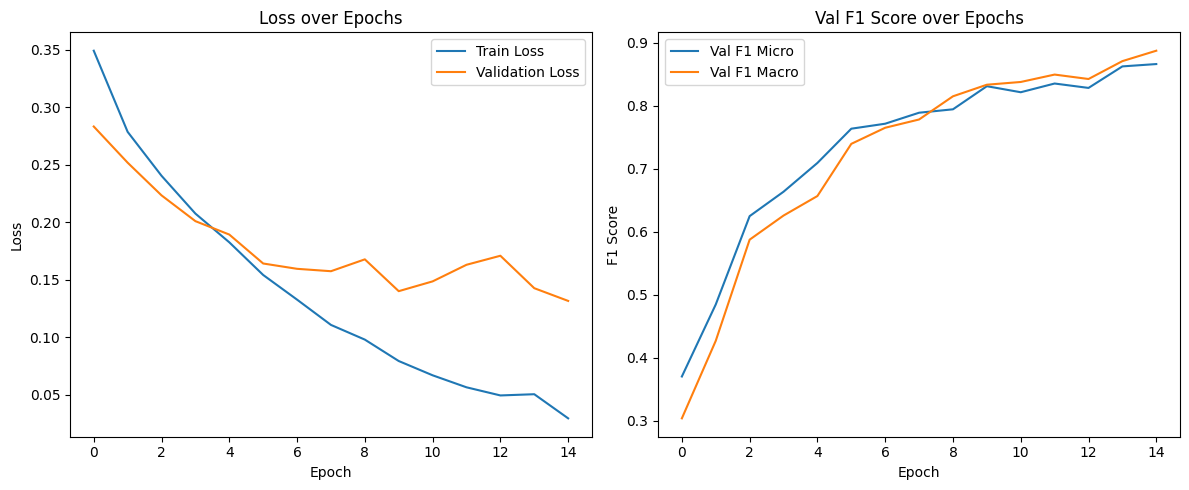

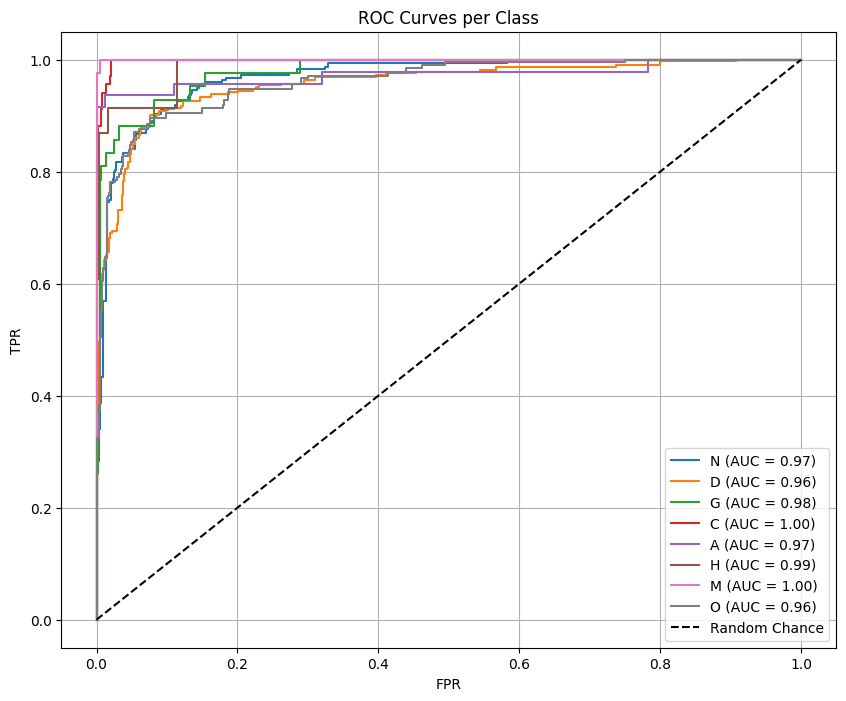

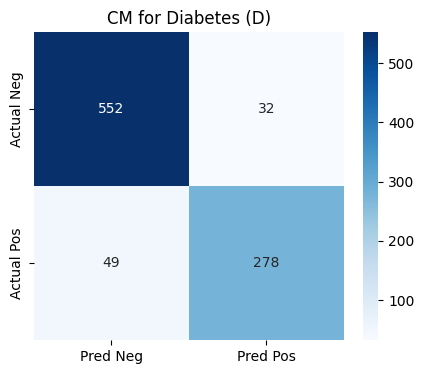

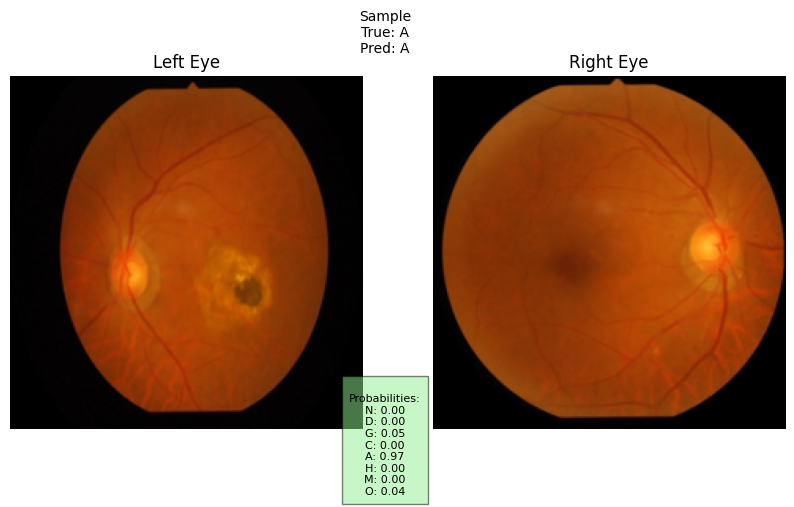

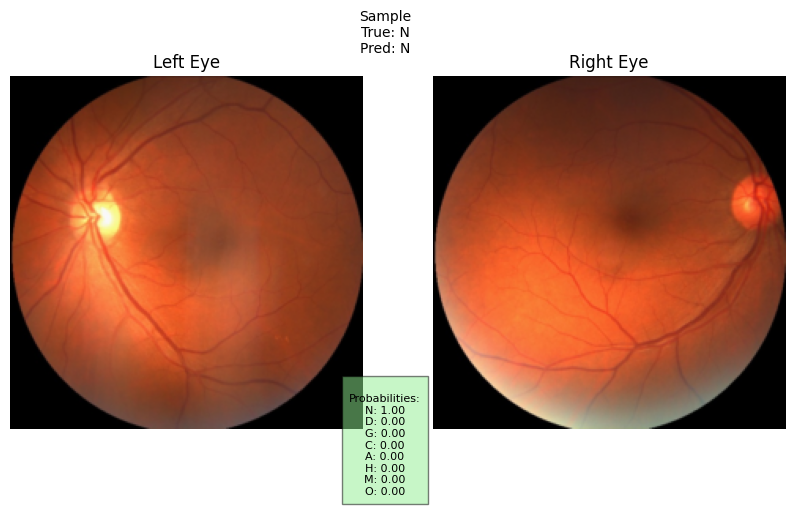

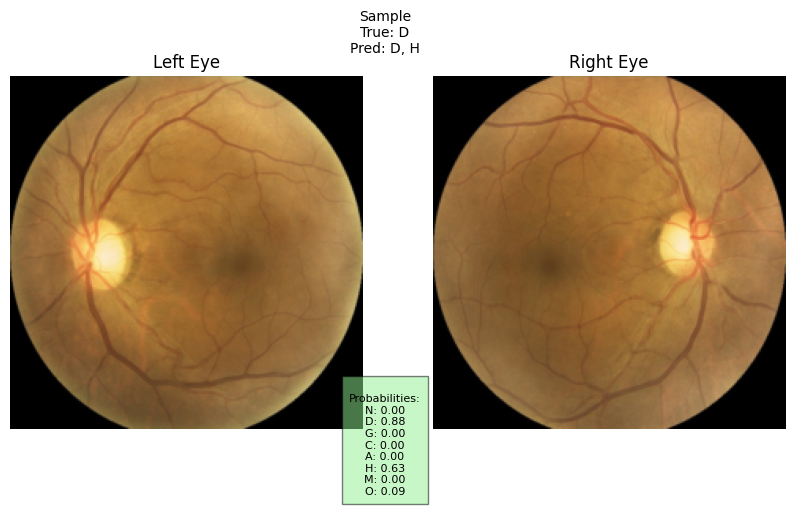

In [ ]:
#model evaluation and visualiztion
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")
else:
    print(f"Warning: Best model path {best_model_path} not found. Evaluating with current model state.")

model.eval()
test_preds_proba = []
test_labels_all = []
progress_bar_test = tqdm(test_loader, desc="Testing", leave=False)
with torch.no_grad():
    for batch in progress_bar_test:
        left_images = batch['left_image'].to(device)
        right_images = batch['right_image'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(left_images, right_images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        test_preds_proba.extend(probs)
        test_labels_all.extend(labels_batch.cpu().numpy())

test_labels_all_np = np.array(test_labels_all)
test_preds_proba_np = np.array(test_preds_proba)
test_preds_binary = (test_preds_proba_np > 0.5).astype(int)

print("\n--- Test Set Evaluation ---")
if len(test_labels_all_np) > 0:
    print("Classification Report (threshold 0.5):")
    print(classification_report(test_labels_all_np, test_preds_binary, target_names=label_columns, zero_division=0))

    test_f1_micro = f1_score(test_labels_all_np, test_preds_binary, average='micro', zero_division=0)
    test_f1_macro = f1_score(test_labels_all_np, test_preds_binary, average='macro', zero_division=0)
    test_hamming = hamming_loss(test_labels_all_np, test_preds_binary)
    print(f"Test F1 Micro: {test_f1_micro:.4f}")
    print(f"Test F1 Macro: {test_f1_macro:.4f}")
    print(f"Test Hamming Loss: {test_hamming:.4f}")
    try:
        test_roc_auc_macro = roc_auc_score(test_labels_all_np, test_preds_proba_np, average='macro', multi_class='ovr')
        print(f"Test ROC AUC (Macro): {test_roc_auc_macro:.4f}")
    except ValueError as e:
        print(f"Could not compute ROC AUC: {e}.")

    # Visualizations
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1_micro'], label='Val F1 Micro')
    plt.plot(history['val_f1_macro'], label='Val F1 Macro')
    plt.title('Val F1 Score over Epochs'); plt.xlabel('Epoch'); plt.ylabel('F1 Score'); plt.legend()
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10, 8))
    for i, label_name in enumerate(label_columns):
        if np.sum(test_labels_all_np[:, i]) > 0 and np.sum(1 - test_labels_all_np[:, i]) > 0 :
            fpr, tpr, _ = roc_curve(test_labels_all_np[:, i], test_preds_proba_np[:, i])
            auc_score = roc_auc_score(test_labels_all_np[:, i], test_preds_proba_np[:, i])
            plt.plot(fpr, tpr, label=f'{label_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves per Class'); plt.legend(loc='lower right'); plt.grid(); plt.show()

    if 'D' in label_columns:
        d_idx = label_columns.index('D')
        cm_d = multilabel_confusion_matrix(test_labels_all_np, test_preds_binary)[d_idx]
        plt.figure(figsize=(5,4)); sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Actual Neg', 'Actual Pos']); plt.title('CM for Diabetes (D)'); plt.show()
else:
    print("Test set is empty. No evaluation metrics to display.")

def display_prediction_samples(num_samples=3):
    if len(test_dataset) == 0:
        print("Test dataset is empty.")
        return
    num_samples = min(num_samples, len(test_dataset))
    if num_samples == 0: return

    sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    unnormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                              std=[1/0.229, 1/0.224, 1/0.225])
    model.eval()
    with torch.no_grad():
        for i in sample_indices:
            data_item = test_dataset[i]
            left_img_tensor = data_item['left_image'].unsqueeze(0).to(device)
            right_img_tensor = data_item['right_image'].unsqueeze(0).to(device)
            true_labels_arr = data_item['labels'].numpy()

            model_output = model(left_img_tensor, right_img_tensor)
            pred_probs = torch.sigmoid(model_output).squeeze(0).cpu().numpy()
            pred_labels_arr = (pred_probs > 0.5).astype(int)

            true_label_names = [label_columns[j] for j, val in enumerate(true_labels_arr) if val == 1]
            pred_label_names = [label_columns[j] for j, val in enumerate(pred_labels_arr) if val == 1]

            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            left_display = np.clip(unnormalize(data_item['left_image']).permute(1, 2, 0).numpy(), 0, 1)
            right_display = np.clip(unnormalize(data_item['right_image']).permute(1, 2, 0).numpy(), 0, 1)
            ax[0].imshow(left_display); ax[0].set_title("Left Eye"); ax[0].axis('off')
            ax[1].imshow(right_display); ax[1].set_title("Right Eye"); ax[1].axis('off')
            plt.suptitle(f"Sample\nTrue: {', '.join(true_label_names) or 'Normal'}\nPred: {', '.join(pred_label_names) or 'Normal'}", fontsize=10)
            prob_text = "\nProbabilities:\n" + "\n".join([f"{lc}: {p:.2f}" for lc, p in zip(label_columns, pred_probs)])
            plt.figtext(0.5, 0.01, prob_text, ha="center", fontsize=8, bbox={"facecolor":"lightgreen", "alpha":0.5, "pad":5})
            plt.show()

display_prediction_samples(num_samples=3)

In [ ]:
!ls /content/drive

MyDrive  Shareddrives
